In [1]:
import math
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import spatial
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

plt.rcParams["figure.figsize"] = (20,5)

import doremus_data

Load data.

In [154]:
training_data_folder = '/Users/pasquale/git/recommender/training_data'
emb_folder = '/Users/pasquale/git/music-embeddings'

doremus_data.init(training_data_folder, emb_folder)
vectors, uris, lbs, heads, heads_print = doremus_data.get_embeddings('artist')
pd.DataFrame(heads_print)

,0,1,2,3,4,5,6
0,mop,birth_date,death_date,casting,function,genre,key
1,3,1,1,3,3,3,3


In [155]:
all_training = doremus_data.all_training('artist')

In [319]:
_l = 3

for t in all_training:
    temp_playlists = []
    for pl in t['playlists']:
        missing = [art not in uris for art in pl['data']]
        pl['data'] = np.delete(pl['data'], np.where(missing))
        if len(pl['data']) < 6 :
            continue
        for i in np.arange(len(pl['data']) - _l):
            temp_playlists.append(pl['data'][i:i+_l])
    t['groups'] = [{'name':str(index), 'data': pl} for index, pl in enumerate(temp_playlists)]
    print('%s\t\t%d' % (t['name'], len(temp_playlists)))

pp_concerts		414
itema3_concerts		1044
web-radio		2504
spotify_pl		2816


In [320]:
def training_stats(t):
    num_playlists = len(t['playlists'])
    num_track = [len(p['data']) for p in t['playlists']]
    distinct = len(np.unique(np.concatenate([p['data'] for p in t['playlists']])))
    return num_playlists, np.sum(num_track), np.mean(num_track), distinct

names = [t['name'] for t in all_training]
# for t in all_training:
#     num_playlists, num_track = training_stats(t)
#     print('%s\t\t%d' % (t['name'], num_playlists))
pd.DataFrame([training_stats(t) for t in all_training], index=names, columns='playlists,tracks,tracks per pl, distinct tracks'.split(','))

,playlists,tracks,tracks per pl,distinct tracks
pp_concerts,223,1031,4.623,715
itema3_concerts,414,2324,5.614,1109
web-radio,155,2973,19.181,738
spotify_pl,70,3026,43.229,1012


Data pre-processing

In [321]:
negVector = -2. * np.ones_like(vectors[0], dtype=np.float32)

def get_embs(x, masked=False):
    # uri to embedding
    v = vectors[np.argwhere(uris == x)]
    if v.size == 0:
        print(x)
        result = np.array(negVector)
    else:
        result = np.array(v[0][0])
    if masked:
        result = np.ma.array(result, mask=result < -1.)
    return result

def get_label(x):
    l =  lbs[np.argwhere(uris == x)]
    return l[0][0] if l.size > 0 else 'none'

In [322]:
np.set_printoptions(2)
def compute_playlist_stats(playlist, to_print=False):
    pl = playlist['data']
    embeddings = np.array([get_embs(xi) for xi in pl])
    emb_len = len(embeddings[0])
    
    ma_embeddings = np.ma.array(embeddings, mask=embeddings < -1.)

    # I do not want to mean dimensions with single values
    mul_values = np.where(np.sum(embeddings >= -1., axis=0) > 1, False, True)
    mul_values = np.repeat([mul_values], len(pl), axis=0)
    ma_embeddings = np.ma.array(ma_embeddings, mask=mul_values)

    _mean = ma_embeddings.mean(axis=0)
    _median = np.ma.median(ma_embeddings, axis=0)
    _min = np.ma.min(ma_embeddings, axis=0)
    _max = np.ma.max(ma_embeddings, axis=0)
    _std = np.ma.std(ma_embeddings, axis=0)
    
    if to_print:
        plt.errorbar(np.arange(len(_mean)), _mean, _std, fmt='ok',
                     ecolor='black', elinewidth=1.5, lw=3, capsize=2)
        plt.errorbar(np.arange(len(_mean)), _mean, [_mean - _min, _max - _mean],
                 fmt='.k', ecolor='gray', elinewidth=0.5, lw=1, capsize=1)

        plt.errorbar(np.arange(len(_mean)), _median, fmt='_g',  lw=1)

        plt.xticks(range(len(heads)), heads, rotation=40)
        plt.show()

    return _mean, _median, _std

Sample playlist

Base: spotify_pl
Playlist: 1023


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/numeric.py:492: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


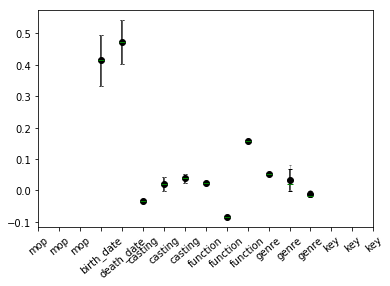

http://overture.doremus.org/artist/10c7575e-ab13-3912-9919-62c0d3003895
Guillaume Dufay
[-- -- -- 0.3333333432674408 0.403809517621994 -0.03878294304013252
 -0.002056780969724059 0.051901187747716904 0.023812396451830864
 -0.08446286618709564 0.15615615248680115 0.05157061666250229
 0.0004409032699186355 -0.01764855533838272 -- -- --]
http://overture.doremus.org/artist/7c8d4e8d-d824-3360-808b-f72e8c88525a
Michael Praetorius
[-- -- -- 0.49619048833847046 0.5438095331192017 -0.027335748076438904
 0.04221932217478752 0.024901214987039566 0.02396547794342041
 -0.08529201149940491 0.15839993953704834 0.04896107316017151
 0.019888639450073242 -0.017865069210529327 -- -- --]
http://overture.doremus.org/artist/dd6c0b38-db65-3eec-b557-6724c3ff3cdf
Antoine Brumel
[-- -- -- -- -- -- -- -- 0.02396547794342041 -0.08529201149940491
 0.15839993953704834 0.057798922061920166 0.08197244256734848
 0.002718365518376231 -- -- --]


In [323]:
base = all_training[3]
print('Base: ' + base['name'])
pl = base['groups'][1023]
print('Playlist: ' + pl['name'])

m, md, s = compute_playlist_stats(pl, True)

for d in pl['data']:
    print(d.replace('data', 'overture'))
    print(get_label(d)) 
    print(np.ma.array(get_embs(d), mask=get_embs(d) < -1.))

Standard Deviation among all playlists

In [324]:
population_tot = np.sum([len(pl['data']) for tr in all_training for pl in tr['groups'] ])
std = {}
population = {}
mean = {}
stdw = {} # std within
stdb = {} # std between
                      
for index, tr in enumerate(all_training):
    name = tr['name']
    std[name] = []
    population[name] = []
    mean[name] = []
    for index, pl in enumerate(tr['groups']):
        _mean, _median, _std = compute_playlist_stats(pl, False)
        pop = len(pl['data'])
        population[name].append(pop)
        mean[name].append(_mean)
        ww = (pop - 1) / (population_tot - 1)
        std[name].append((_std**2)*ww)

    stdw[name] = np.ma.sum(std[name], axis=0).filled(0)

In [325]:
weighted_means = [np.ma.mean(mean[name], axis=0)*np.sum(population[name]) for name in mean]

mtot = np.ma.sum(weighted_means, axis=0)
mtot /= population_tot

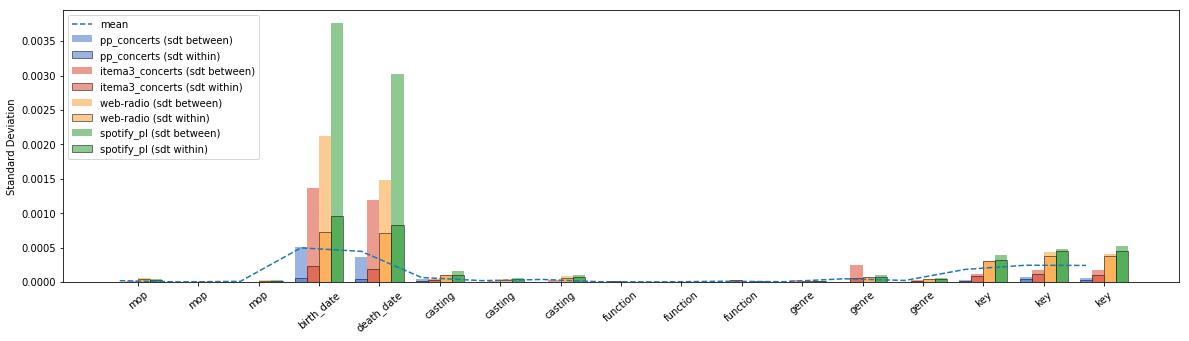

Standard Deviation: mean
[2.23e-05 4.37e-06 1.27e-05 4.99e-04 4.48e-04 6.77e-05 2.27e-05 3.99e-05
 5.58e-06 5.29e-06 1.36e-05 7.39e-06 4.99e-05 2.54e-05 1.85e-04 2.46e-04
 2.43e-04]
Standard Deviation: minimum
[3.98e-06 1.06e-06 2.62e-06 5.98e-05 5.17e-05 2.14e-05 3.36e-06 4.09e-06
 1.64e-06 3.51e-06 6.93e-06 1.01e-06 7.81e-06 3.64e-06 2.29e-05 4.14e-05
 3.05e-05]
Standard Deviation between: mean
[3.02e-05 6.18e-06 1.88e-05 1.94e-03 1.52e-03 8.70e-05 3.33e-05 5.70e-05
 5.71e-06 4.07e-06 1.31e-05 1.51e-05 1.12e-04 3.64e-05 2.14e-04 2.97e-04
 2.92e-04]


In [326]:
fig, ax = plt.subplots(figsize=(20,5))
width = 0.2
pos = np.arange(len(vectors[0]))
colors = ['#3668C9', '#DA3B21', '#FD9827', '#1D9424']


for index, tr in enumerate(all_training):
    name = tr['name']
    
    ww = np.array([pop / (population_tot - 1) for pop in population[name]])
    mg = np.ma.power(np.ma.array(mean[name]).filled(mtot) - mtot, 2)
    stdb[name] = np.ma.sum(mg * ww.reshape(len(ww),1), axis=0)

    plt.bar([p + index * width for p in pos],
        stdb[name],
        width,
        alpha=0.5,
        color=colors[index],
        label=name + ' (sdt between)')
    
    plt.bar([p + index * width for p in pos],
        stdw[name] ,
        width,
        edgecolor='#000000',
        alpha=.5,
        color=colors[index],
        label=name + ' (sdt within)')
    

    
flat_std = [stdw[name] for name in stdw]
mstd = np.ma.mean(flat_std, axis=0)
sstd = np.ma.std(flat_std, axis=0)
smin = np.ma.min(flat_std, axis=0)
smax = np.ma.max(flat_std, axis=0)

ax.plot(pos, mstd, '--', label='mean')

plt.xticks(range(len(heads)), heads, rotation=40)
ax.set_ylabel('Standard Deviation')
ax.set_xticks([p + 1.5 * width for p in pos])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left')
plt.show()

print('Standard Deviation: mean' )
print(np.array(mstd))
print('Standard Deviation: minimum' )
print(np.array(smin))

flat_std_b = [stdb[name] for name in stdb]
mstd_b = np.ma.mean(flat_std_b, axis=0)
print('Standard Deviation between: mean' )
print(np.array(mstd_b))

#### Explaination

When the standard deviation _within_ (black border) is smaller then the standard deviation _between_ (no border), this means that for that dimension the values are more homogeneous _inside_ the group than _outside_.
If this difference in homogeneity inside/outside is important, I can state that this dimension drives the playlist generation.

### Graphs property by property

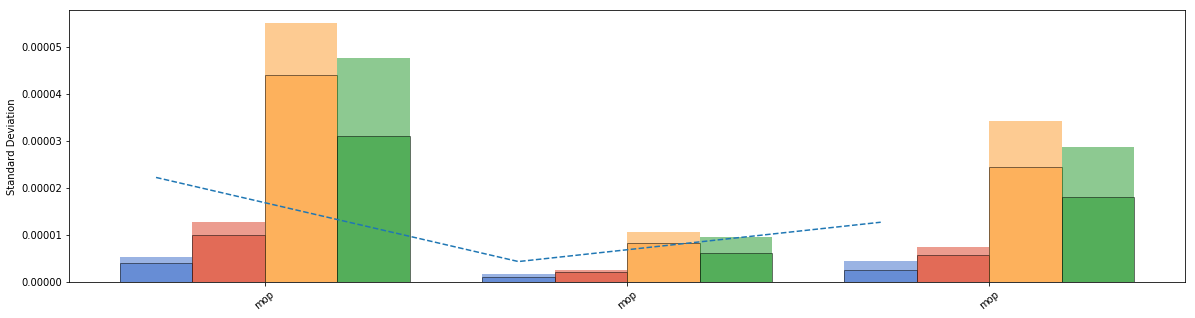

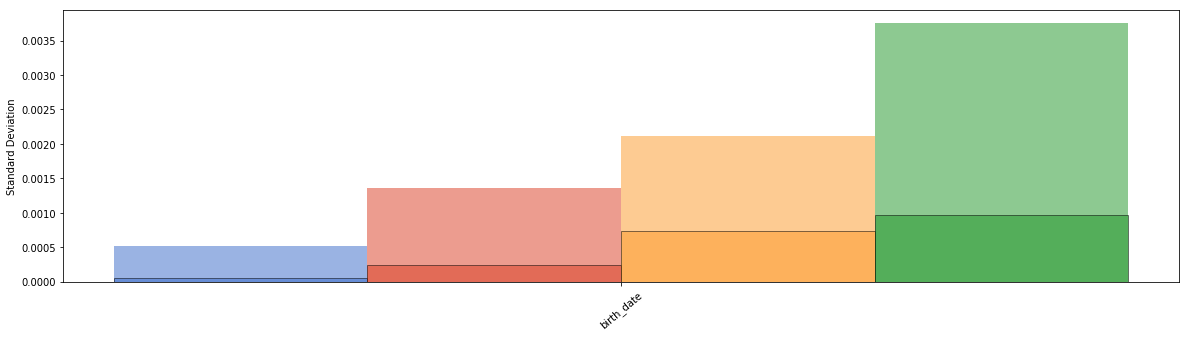

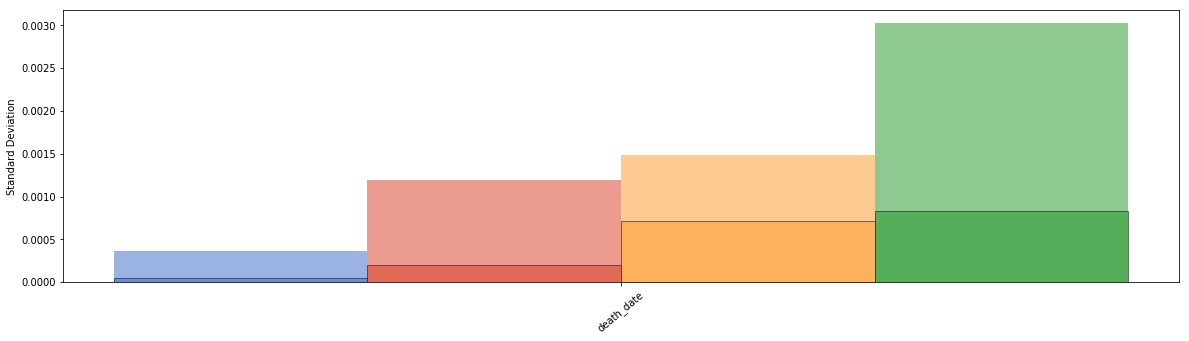

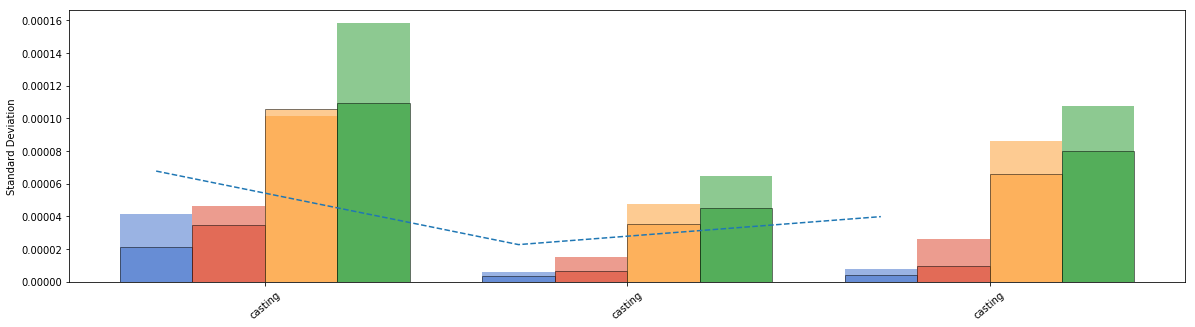

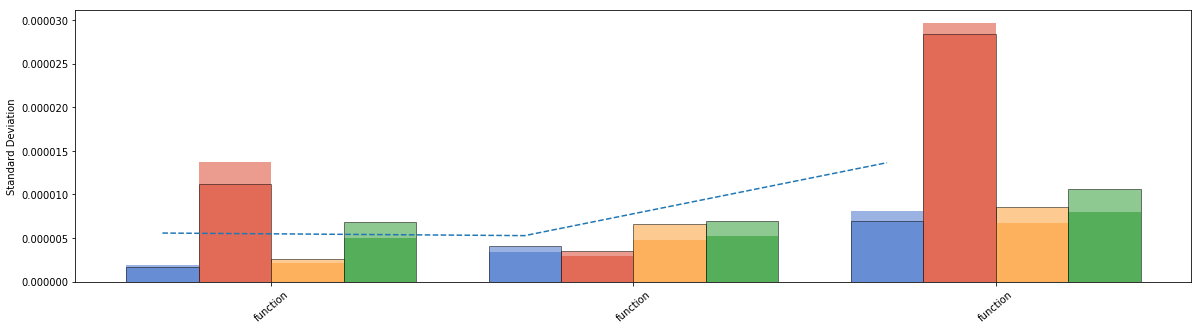

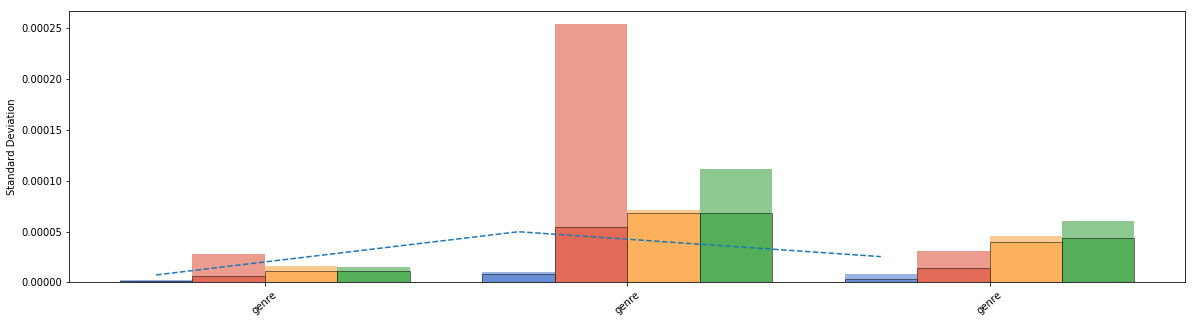

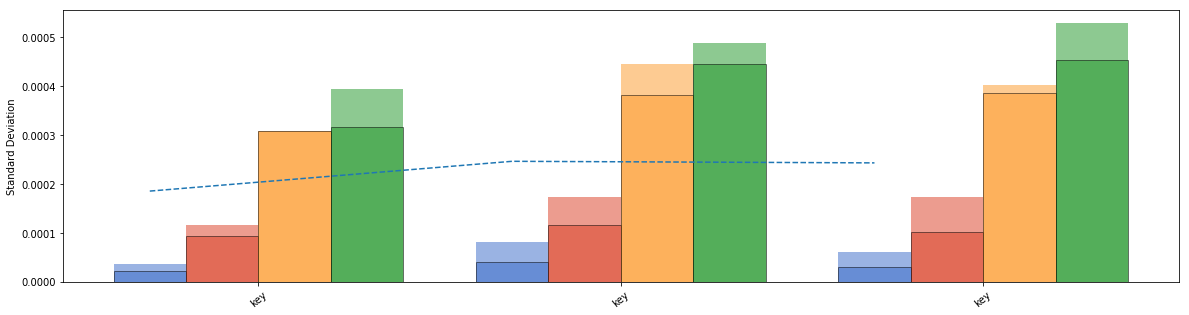

In [327]:
def display_graph(feat):
    pos = np.where(np.array(heads) == feat)[0]
    pos_slide = np.arange(len(pos))
    fig, ax = plt.subplots(figsize=(20,5))

    for index, tr in enumerate(all_training):
        name = tr['name']
        plt.bar([p + index * width for p in pos_slide],
            stdb[name][pos],
            width,
            alpha=0.5,
            color=colors[index],
            label=name + ' (sdt between)')

        plt.bar([p + index * width for p in pos_slide],
            stdw[name][pos] ,
            width,
            alpha=0.5,
            edgecolor='#000000',
            color=colors[index],
            label=name + ' (sdt within)')

    ax.plot(pos_slide, mstd[pos], '--', label='mean')

    plt.xticks(pos_slide, np.array(heads)[pos], rotation=40)
    ax.set_ylabel('Standard Deviation')
    ax.set_xticks([p + 1.5 * width for p in pos_slide])
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles, labels, loc='upper left')
    plt.show()
    
    
for _f in heads_print[0]:
    display_graph(_f)

For concerts

In [328]:
flat_std = [s for name in ['pp_concerts','itema3_concerts'] for s in std[name]]
mstd = np.ma.mean(flat_std, axis=0)
sstd = np.ma.std(flat_std, axis=0)
smin = np.ma.min(flat_std, axis=0)
smax = np.ma.max(flat_std, axis=0)

print('Standard Deviation: mean' )
print(np.array(mstd))
print('Standard Deviation: minimum' )
print(np.array(smin))
print('Standard Deviation: maximum' )
print(np.array(smax))

Standard Deviation: mean
[7.56e-08 1.69e-08 4.53e-08 2.50e-07 2.46e-07 7.11e-08 1.27e-08 1.73e-08
 8.84e-09 5.24e-09 2.42e-08 5.97e-09 4.89e-08 1.39e-08 2.34e-07 3.16e-07
 2.67e-07]
Standard Deviation: minimum
[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.49e-18 1.58e-17 2.49e-16
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.01e-12 9.83e-14
 1.87e-14]
Standard Deviation: maximum
[2.46e-07 8.29e-08 2.86e-07 1.17e-05 1.17e-05 6.58e-07 2.30e-07 2.16e-07
 2.30e-07 7.32e-07 7.96e-07 7.02e-08 3.29e-07 2.40e-07 3.29e-06 4.17e-06
 2.74e-06]


For playlists

In [329]:
flat_std = [s for name in ['web-radio','spotify_pl'] for s in std[name]]
mstd = np.ma.mean(flat_std, axis=0)
sstd = np.ma.std(flat_std, axis=0)
smin = np.ma.min(flat_std, axis=0)
smax = np.ma.max(flat_std, axis=0)


print('Standard Deviation: mean' )
print(np.array(mstd))
print('Standard Deviation: minimum' )
print(np.array(smin))
print('Standard Deviation: maximum' )
print(np.array(smax))

Standard Deviation: mean
[7.19e-08 1.37e-08 4.08e-08 3.20e-07 3.62e-07 4.15e-08 1.56e-08 2.81e-08
 1.77e-09 2.54e-09 3.61e-09 4.16e-09 2.60e-08 1.59e-08 1.91e-07 2.52e-07
 2.56e-07]
Standard Deviation: minimum
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Standard Deviation: maximum
[5.17e-07 1.32e-07 1.69e-07 9.69e-06 9.73e-06 9.46e-07 2.22e-07 3.84e-07
 5.79e-07 1.65e-06 7.90e-07 1.02e-07 3.63e-07 2.29e-07 4.10e-06 5.30e-06
 5.08e-06]


# Computing gaps

In [330]:
def get_std_gap(_chosen):
#     return (stdb[_chosen] - stdw[_chosen]) / ((stdw[_chosen] + stdb[_chosen]) / 2 )
    return  stdb[_chosen] / stdw[_chosen]

def display_distances(_chosen):
    better =(stdw[_chosen]<=stdb[_chosen]).tolist()
    distance = get_std_gap(_chosen)

    pd.set_option('precision', 3)
    return pd.DataFrame([better, distance.tolist(), stdw[_chosen].tolist(), stdb[_chosen].tolist()], 
                        index=['homongeneous', '% rate', 'std within', 'std between'], columns=heads)

In [331]:
display_distances('spotify_pl')

,mop,mop,mop,birth_date,death_date,casting,casting,casting,function,function,function,genre,genre,genre,key,key,key
homongeneous,True,True,True,True,True,True,True,True,False,False,False,True,True,True,True,True,True
% rate,1.53,1.58,1.59,3.9,3.63,1.45,1.42,1.35,0.739,0.748,0.755,1.36,1.63,1.37,1.25,1.09,1.17
std within,3.11e-05,6.14e-06,1.81e-05,0.000964,0.000832,0.000109,4.54e-05,7.99e-05,6.86e-06,6.94e-06,1.06e-05,1.09e-05,6.85e-05,4.38e-05,0.000316,0.000446,0.000454
std between,4.77e-05,9.67e-06,2.87e-05,0.00376,0.00302,0.000158,6.46e-05,0.000108,5.07e-06,5.19e-06,8.01e-06,1.48e-05,0.000112,6.02e-05,0.000395,0.000488,0.00053


In [332]:
display_distances('web-radio')

,mop,mop,mop,birth_date,death_date,casting,casting,casting,function,function,function,genre,genre,genre,key,key,key
homongeneous,True,True,True,True,True,False,True,True,False,False,False,True,True,True,False,True,True
% rate,1.25,1.3,1.4,2.9,2.09,0.958,1.33,1.31,0.816,0.735,0.787,1.47,1.05,1.15,1,1.16,1.05
std within,4.41e-05,8.22e-06,2.45e-05,0.000729,0.000711,0.000106,3.55e-05,6.59e-05,2.58e-06,6.57e-06,8.61e-06,1.1e-05,6.84e-05,3.99e-05,0.000309,0.000383,0.000386
std between,5.51e-05,1.07e-05,3.44e-05,0.00212,0.00149,0.000101,4.74e-05,8.61e-05,2.11e-06,4.83e-06,6.77e-06,1.61e-05,7.17e-05,4.58e-05,0.000309,0.000445,0.000404


In [333]:
display_distances('pp_concerts')

,mop,mop,mop,birth_date,death_date,casting,casting,casting,function,function,function,genre,genre,genre,key,key,key
homongeneous,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True
% rate,1.34,1.71,1.74,8.66,7.04,1.95,1.76,1.97,1.2,0.816,1.17,2.01,1.31,2.31,1.55,1.97,2
std within,3.98e-06,1.06e-06,2.62e-06,5.98e-05,5.17e-05,2.14e-05,3.36e-06,4.09e-06,1.64e-06,4.13e-06,6.93e-06,1.01e-06,7.81e-06,3.64e-06,2.29e-05,4.14e-05,3.05e-05
std between,5.34e-06,1.81e-06,4.55e-06,0.000518,0.000363,4.18e-05,5.9e-06,8.04e-06,1.97e-06,3.37e-06,8.11e-06,2.02e-06,1.03e-05,8.43e-06,3.54e-05,8.15e-05,6.09e-05


In [334]:
display_distances('itema3_concerts')

,mop,mop,mop,birth_date,death_date,casting,casting,casting,function,function,function,genre,genre,genre,key,key,key
homongeneous,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True
% rate,1.29,1.26,1.32,5.65,6.07,1.35,2.29,2.73,1.22,0.826,1.04,4.15,4.65,2.21,1.25,1.5,1.69
std within,9.92e-06,2.05e-06,5.71e-06,0.000241,0.000197,3.46e-05,6.68e-06,9.57e-06,1.12e-05,3.51e-06,2.84e-05,6.64e-06,5.48e-05,1.41e-05,9.33e-05,0.000116,0.000102
std between,1.28e-05,2.58e-06,7.55e-06,0.00136,0.00119,4.66e-05,1.53e-05,2.62e-05,1.37e-05,2.9e-06,2.96e-05,2.76e-05,0.000255,3.12e-05,0.000116,0.000173,0.000173


2 different tendences between concerts and playlists.

In **concerts** all the dimensions (where they exist) are more homogeneous. This is true in particular for the **casting** (not to be used instead for playlists), and this is reasonable.

The 1st dimension of **composer** is also one to take in account.
In Itema3 this is not visible probably because of bad interlinking of artists.

For the keys, the values are not so relevant and not stable in positiveness.

Always positive (in **bold** the largely ones):
- **composer[0]**
- composer[1,2]
- **genre[2]**
- composition_date
- key[2]
- casting[2]

Positive only in concerts:
- **casting[all]**
- **genre[all]**
- **composition_date**



----
# Tuning the recommender system

In [335]:
def compute_weights(threshold=1.4, fallback = .6, datasets =['spotify_pl']):
    dist = [get_std_gap(_chosen) for _chosen in datasets]
    dist = np.ma.mean(dist, axis=0).filled()

    return np.where(dist > threshold, dist, fallback)

w = compute_weights()
pd.DataFrame([w], columns=heads)

,mop,mop,mop,birth_date,death_date,casting,casting,casting,function,function,function,genre,genre,genre,key,key,key
0,1.535,1.576,1.588,3.899,3.631,1.45,1.422,0.6,0.6,0.6,0.6,0.6,1.629,0.6,0.6,0.6,0.6


In [336]:
def get_pool_from_datasets(datasets=['web-radio','spotify_pl']):
    all_song = []
    for t in all_training:
        if t['name'] in datasets:
            for pl in t['playlists']:
                missing = [art not in uris for art in pl['data']]
                pl['data'] = np.delete(pl['data'], np.where(missing))
                all_song = np.concatenate([all_song, pl['data']])
    all_song = np.unique(all_song)
    print('Pool size: %d' % len(all_song))
    all_song_vec = np.ma.array([get_embs(xi, masked=True) for xi in all_song])
#     all_song_vec = np.ma.array(all_song_vec, mask=all_song_vec < -1.)
    all_song_labels = np.array([get_label(xi) for xi in all_song])
    return all_song, all_song_vec, all_song_labels

In [337]:
def computeSimilarity(seed, target, w):
    b1 = np.where(seed.mask==True)[0]
    b2 = np.where(target.mask==True)[0]
    bad_pos = np.unique(np.concatenate([b1, b2]))

    _seed = np.delete(seed, bad_pos, axis=0)
    _target = np.delete(target, bad_pos, axis=0)
    _w = np.delete(w, bad_pos, axis=0)

    if len(_seed) == 0:
        return 0

    # distance
    d = weightedL2(_seed, _target, _w)

    # how much info I am not finding
    penalty = len([x for x in b2 if x not in b1]) / len(seed)

    # score
    s = (max_distance - d) / max_distance
    return s * (1 - penalty)


def weightedL2(a, b, w=1):
#     return distance.cosine(a,b)
    # https://stackoverflow.com/a/8861999/1218213
    q = a - b
    return np.sqrt((w * q * q).sum())
#     return (w * q * q).sum()


_ones = np.ones(vectors[0].shape)
max_distance = weightedL2(_ones,-_ones, _ones)

In [338]:
def find(seed, n=4, w=None, _print=True, pool=get_pool_from_datasets()):
    global max_distance
    
    _uris =  pool[0]
    _vectors = pool[1]
    _lbs = pool[2]

    
    f_length = len(seed)
    
    _seed = seed
    
    if w is None:
        w = np.ones(len(_seed))
        w = w / w.sum()
    else:
        w = np.array(w)
#         temp = [np.ones(f_length[k]) * w[k] for k in range(len(w))]
#         w = np.array([item for sublist in temp for item in sublist])

    max_distance = weightedL2(np.ones(len(_seed)), np.ones(len(_seed)) * -1, w)

    if _print==True: print('computing scores')
    scores = np.array([[computeSimilarity(_seed, x.astype(float), w) for x in _vectors]])
    full = np.concatenate([_uris.reshape(len(_uris), 1), scores.transpose(), _lbs.reshape(len(_uris), 1)], axis=1)

    # remove the seed from the list
#     full = np.delete(full, pos, 0)

    # sort
    full_sorted = sorted(full, key=lambda _x: float(_x[1]), reverse=True)
    most_similar = full_sorted[:n]
    if _print==True: print('\n'.join('%s %s\n%s' % (f[0], f[1], f[2]) for f in most_similar))

    return [{'uri': _a[0], 'score': float(_a[1])} for _a in most_similar]

Pool size: 1396


In [360]:
find(get_embs('http://data.doremus.org/artist/b34f92ab-ad86-361b-a8b8-5c3a4db784d0', masked=True))

computing scores
http://data.doremus.org/artist/b34f92ab-ad86-361b-a8b8-5c3a4db784d0 1.0
Antonio Vivaldi
http://data.doremus.org/artist/a82b0c56-ccdf-31b6-a8b4-ad065f3405e5 0.9964103762560376
Tomaso Albinoni
http://data.doremus.org/artist/aa9564af-3ccd-36dc-8112-c6f0a67dfdbe 0.9951215281279058
Francesco Geminiani
http://data.doremus.org/artist/d07ec69a-da7c-36ab-a098-44c0cdc9741d 0.9946926919629068
Alessandro Scarlatti


[{'score': 1.0,
  'uri': 'http://data.doremus.org/artist/b34f92ab-ad86-361b-a8b8-5c3a4db784d0'},
 {'score': 0.9964103762560376,
  'uri': 'http://data.doremus.org/artist/a82b0c56-ccdf-31b6-a8b4-ad065f3405e5'},
 {'score': 0.9951215281279058,
  'uri': 'http://data.doremus.org/artist/aa9564af-3ccd-36dc-8112-c6f0a67dfdbe'},
 {'score': 0.9946926919629068,
  'uri': 'http://data.doremus.org/artist/d07ec69a-da7c-36ab-a098-44c0cdc9741d'}]

In [361]:
find(get_embs('http://data.doremus.org/artist/b82c0771-5280-39af-ad2e-8ace2f4ebda3', masked=True))

computing scores
http://data.doremus.org/artist/b82c0771-5280-39af-ad2e-8ace2f4ebda3 1.0
Giuseppe Verdi
http://data.doremus.org/artist/e432aa13-207f-34f8-9792-d1d15fcd4711 0.9911241891983096
Georges Bizet
http://data.doremus.org/artist/08499468-c1b5-35d2-958f-134bc11c9c7a 0.9909344312170096
Ruggero Leoncavallo
http://data.doremus.org/artist/95bb7ab4-648d-3d95-beae-4dfc17530aec 0.9904420982664395
Benjamin Godard


[{'score': 1.0,
  'uri': 'http://data.doremus.org/artist/b82c0771-5280-39af-ad2e-8ace2f4ebda3'},
 {'score': 0.9911241891983096,
  'uri': 'http://data.doremus.org/artist/e432aa13-207f-34f8-9792-d1d15fcd4711'},
 {'score': 0.9909344312170096,
  'uri': 'http://data.doremus.org/artist/08499468-c1b5-35d2-958f-134bc11c9c7a'},
 {'score': 0.9904420982664395,
  'uri': 'http://data.doremus.org/artist/95bb7ab4-648d-3d95-beae-4dfc17530aec'}]

In [362]:
find(get_embs('http://data.doremus.org/artist/03954109-0253-35d6-a70e-89ab27dea09c', masked=True))

computing scores
http://data.doremus.org/artist/03954109-0253-35d6-a70e-89ab27dea09c 1.0
Franz Schubert
http://data.doremus.org/artist/4802a043-23bb-3b8d-a443-4a3bd22ccc63 0.9873076232261836
Wolfgang Amadeus Mozart
http://data.doremus.org/artist/00f6e16d-7cd8-3d52-ad65-5f5e85e42123 0.9870996483784845
Frédéric Chopin
http://data.doremus.org/artist/6963af5e-b126-3d40-a84b-97e0b78f5452 0.9870906915807572
Ludwig van Beethoven


[{'score': 1.0,
  'uri': 'http://data.doremus.org/artist/03954109-0253-35d6-a70e-89ab27dea09c'},
 {'score': 0.9873076232261836,
  'uri': 'http://data.doremus.org/artist/4802a043-23bb-3b8d-a443-4a3bd22ccc63'},
 {'score': 0.9870996483784845,
  'uri': 'http://data.doremus.org/artist/00f6e16d-7cd8-3d52-ad65-5f5e85e42123'},
 {'score': 0.9870906915807572,
  'uri': 'http://data.doremus.org/artist/6963af5e-b126-3d40-a84b-97e0b78f5452'}]

In [370]:
find(get_embs('http://data.doremus.org/artist/bcf39e82-e208-3049-b550-1feaae6071a6', masked=True))

computing scores
http://data.doremus.org/artist/bcf39e82-e208-3049-b550-1feaae6071a6 1.0
Claude Debussy
http://data.doremus.org/artist/f9a2ac39-a62d-3be2-8abb-e564de0ec96d 0.9931615991322305
Johannes Brahms
http://data.doremus.org/artist/157157ef-1cb3-3fc7-a4f7-2531989fc942 0.9909424255922206
Richard Strauss
http://data.doremus.org/artist/72b3b303-5c15-319f-9c31-dc73b5b0fe74 0.9908471438205945
Jean Sibelius


[{'score': 1.0,
  'uri': 'http://data.doremus.org/artist/bcf39e82-e208-3049-b550-1feaae6071a6'},
 {'score': 0.9931615991322305,
  'uri': 'http://data.doremus.org/artist/f9a2ac39-a62d-3be2-8abb-e564de0ec96d'},
 {'score': 0.9909424255922206,
  'uri': 'http://data.doremus.org/artist/157157ef-1cb3-3fc7-a4f7-2531989fc942'},
 {'score': 0.9908471438205945,
  'uri': 'http://data.doremus.org/artist/72b3b303-5c15-319f-9c31-dc73b5b0fe74'}]

In [339]:
def recommend_compare(playlist, w, pos=-1, num_candidates=[100, 200, 500],
                      verbose=True, pool=get_pool_from_datasets(), overture=True):
    pl_data = playlist['data']
    pl_population = len(pl_data)
    if verbose: print('%d items | %s' % (pl_population, playlist['name'].split('/')[-1]))
    
    _replcm = 'overture.' if overture else 'data.'
    
    if pos < 0:
        pos = random.randrange(pl_population)
   
    chosen = pl_data[pos]
    targets = pl_data
#     [max(pos-7,0):min(pos+7, len(pl_data))]
    targets_pop = len(targets)
#     print(max(pos-5,0))
#     print(min(pos+5, len(pl_data)))
#     print(targets_pop)

    if verbose: 
        print('seed: %d) %s' % (pos, get_label(chosen)))
        print('\t '+ chosen.replace('data.', _replcm))

    
    first = get_embs(chosen, masked=True)

    candidates = find(first, n=np.max(num_candidates), _print=False, pool=pool )
    candidates_2 = find(first, n=np.max(num_candidates), _print=False, w = w, pool=pool )
    
    results = np.zeros((len(num_candidates), 3))
    
    for qi, q in enumerate(num_candidates):
        trues_flat = 0
        for index, c in enumerate(candidates[:q]):
            if c['uri'] == chosen: continue
            if c['uri'] in targets: trues_flat+=1
#             if verbose:
#                 _sig = '  X  ' if c['uri'] in targets else '   '
#                 print('%d \t %.5f'% (index, c['score']) + '\t' + _sig + '\t' + get_label(c['uri']))
#                 print('\t\t\t\t'+ c['uri'].replace('data.', 'overture.'))
        #     display(pd.DataFrame(np.ma.array( candidates[c]).reshape(1, 13)))


        trues = 0
        for index, c in enumerate(candidates_2[:q]):
            if c['uri'] == chosen: continue
            if c['uri'] in targets: trues+=1
#             if verbose:
#                 _sig = '  X  ' if c['uri'] in pl_data else '   '
#                 print('%d \t %.5f'% (index, c['score']) + '\t' + _sig + '\t' + get_label(c['uri']))
#                 print('\t\t\t\t'+ c['uri'].replace('data.', 'overture.'))
#                 # display(pd.DataFrame(np.ma.array( candidates[c]).reshape(1, 13)))

        if verbose: print('%d | flat %d | weighted %d | diff %d' % (q, trues_flat, trues, trues-trues_flat))
        results[qi] = [trues / targets_pop, trues_flat / targets_pop, (trues-trues_flat) / targets_pop]
    return results

Pool size: 1396


In [340]:
# w = compute_weights(threshold=1.2, fallback=1., datasets=['spotify_pl'])
pl = all_training[3]['playlists'][12]
recommend_compare(pl, w)

92 items | 37i9dQZF1DWWEJlAGA9gs0.Classical Essentials.artist.txt
seed: 88) Giacomo Puccini
	 http://overture.doremus.org/artist/5bcd515f-354f-30f8-ae0a-c42b65536d9f
100 | flat 17 | weighted 21 | diff 4
200 | flat 37 | weighted 38 | diff 1
500 | flat 55 | weighted 54 | diff -1


array([[ 0.23,  0.18,  0.04],
       [ 0.41,  0.4 ,  0.01],
       [ 0.59,  0.6 , -0.01]])

### Computation on all playlists

In [341]:
out_path = './out-artists'

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    return file_path

from tqdm import tqdm_notebook as tqdm

In [342]:
def test_recommendation(pool, playlist, pos=-1, mode='random', w=None, name='', verbose=0, overture=False, write=False):
    pl_data = playlist['data']
    pl_population = len(pl_data)
    pl_name = playlist['name'].split('/')[-1].replace('.json', '')
    
    _replcm = 'overture.' if overture else 'data.'

    if pos < 0:
        pos = random.randrange(pl_population)
    chosen = pl_data[pos]
    pl_data = np.delete(pl_data, pos, axis=0)

    if verbose > 0: 
        print('%d items | %s' % (pl_population, pl_name))
        print('seed: %d) %s' % (pos, get_label(chosen)))
        print('\t '+ chosen.replace('data.', _replcm))

    
    first = get_embs(chosen, masked=True)
    num_candidates=[100, 200, 500]
    max_candidates = np.max(num_candidates)

    if mode == 'flat':
        candidates = find(first, n=max_candidates, _print=False, pool=pool)
    elif mode == 'weighted':
        candidates = find(first, n=max_candidates, _print=False, w = w, pool=pool)
    else : # random
        candidates =  list(map(lambda x: {'uri': x, 'score': 0}, random.sample(pool[0].tolist(), 500)))

    results = np.zeros(len(num_candidates))
    candidates_uri =  list(map(lambda x: x['uri'], candidates))

    for qi, q in enumerate(num_candidates):
        trues = len(set(candidates_uri[:q]).intersection(set(pl_data)))
        
        if verbose > 0:
            print('%d | positive %d | population %d' % (q, trues, pl_population))
        results[qi] = trues

    if verbose > 1:
        for index, c in enumerate(candidates[:max_candidates]):
            _sig = '  X  ' if c['uri'] in pl_data else '   '
            print('%d \t %.5f'% (index, c['score']) + '\t' + _sig + '\t' + get_label(c['uri']))
            print('\t\t\t\t'+ c['uri'].replace('data.', _replcm))
            # display(pd.DataFrame(np.ma.array( candidates[c]).reshape(1, 13)))

    if write:
        to_write =[';'.join([
                    str(index),
                    str(c['score']), 
                    '1' if c['uri'] in pl_data else '0',
                    get_label(c['uri']),
                    c['uri'].replace('[;\n"]', ' ')
                   ])
            for index, c in enumerate(candidates[:max_candidates])]

        filename = pl_name + '.' + str(pos) + '.csv'
        with open(ensure_dir(os.path.join(out_path, 'detail', name, filename)), 'w') as file:
            file.write('index;score;predicted;label;uri\n')
            file.write('\n'.join(to_write))

    return results

In [348]:
def run_for_dataset(id_dataset, pool, mode='random', w=None, name=''):
    with open(ensure_dir(os.path.join(out_path, 'summary', name + '.csv')), 'w') as file:
        file.write('index;playlist;population;predicted100;predicted200;predicted500\n')
        testset = all_training[id_dataset]['playlists']
        
        pbar = tqdm(total=len(testset))

        for index, pl in enumerate(testset):
            population = len(pl['data'])
            pl_name = pl['name'].split('/')[-1].replace('.json', '').replace('"','')

            results = [test_recommendation(pool=pool, playlist=pl, pos=pos,  
                                    mode=mode, w=w, write=False, name=name)
                       for pos, work in enumerate(pl['data'])]
            results = np.mean(results,axis=0)
            
            pbar.update(1)
            if not 'ndarray' in str(type(results)):
#                 print(type(results))
                continue

            file.write(';'.join([str(index), pl_name, str(population), 
                                 str(results[0]), str(results[1]), str(results[2])]))
            file.write('\n')
    pbar.close()

In [344]:
# test_recommendation(pp_pool, playlist=all_training[0]['playlists'][4], mode='weighted', name='pp.w5-06', w=_wpp, verbose=2 )

In [345]:
# itema3_pool = get_pool_from_datasets(['itema3_concerts'])

In [346]:
run_for_dataset(1, itema3_pool, mode='random', name='itema3.rand')

HBox(children=(IntProgress(value=0, max=414), HTML(value='')))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<class 'numpy.float64'>
<class 'numpy.float64'>


In [347]:
run_for_dataset(1, itema3_pool, mode='flat', name='itema3.flat')

HBox(children=(IntProgress(value=0, max=414), HTML(value='')))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<class 'numpy.float64'>
<class 'numpy.float64'>


In [350]:
_wi3 = compute_weights(threshold=1.4, datasets=['itema3_concerts'])
run_for_dataset(1, itema3_pool, mode='weighted', name='itema3.w14-06', w= _wi3)

HBox(children=(IntProgress(value=0, max=414), HTML(value='')))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
_wi3 = compute_weights(threshold=8, datasets=['itema3_concerts'])
run_for_dataset(1, itema3_pool, mode='weighted', name='itema3.w8-06', w= _wi3)

In [ ]:
_wi3 = compute_weights(threshold=10, datasets=['itema3_concerts'])
run_for_dataset(1, itema3_pool, mode='weighted', name='itema3.w10-06', w= _wi3)

In [ ]:
_wi3 = compute_weights(threshold=8, fallback=1., datasets=['itema3_concerts'])
run_for_dataset(1, itema3_pool, mode='weighted', name='itema3.w8-1', w= _wi3)

In [ ]:
_wi3 = compute_weights(threshold=5, datasets=['itema3_concerts', 'pp_concerts'])
run_for_dataset(1, itema3_pool, mode='weighted', name='itema3.wp5-06', w= _wi3)

In [353]:
pp_pool = get_pool_from_datasets(['pp_concerts'])

Pool size: 715


In [371]:
run_for_dataset(0, pp_pool, mode='random', name='pp.rand')

HBox(children=(IntProgress(value=0, max=223), HTML(value='')))

In [372]:
run_for_dataset(0, pp_pool, mode='flat', name='pp.flat')

HBox(children=(IntProgress(value=0, max=223), HTML(value='')))

In [373]:
_wpp = compute_weights(threshold=2, datasets=['pp_concerts'])
pd.DataFrame([_wpp], columns=heads)

,mop,mop,mop,birth_date,death_date,casting,casting,casting,function,function,function,genre,genre,genre,key,key,key
0,0.6,0.6,0.6,8.657,7.036,0.6,0.6,0.6,0.6,0.6,0.6,2.009,0.6,2.315,0.6,0.6,0.6


In [374]:
run_for_dataset(0, pp_pool, mode='weighted', name='pp.w2-06', w=_wpp)

HBox(children=(IntProgress(value=0, max=223), HTML(value='')))

In [376]:
spo_pool = get_pool_from_datasets(['spotify_pl'])

Pool size: 1012


In [377]:
run_for_dataset(3, spo_pool, mode='random', name='spotify.rand')

HBox(children=(IntProgress(value=0, max=70), HTML(value='')))

In [378]:
run_for_dataset(3, spo_pool, mode='flat', name='spotify.flat')

HBox(children=(IntProgress(value=0, max=70), HTML(value='')))

In [379]:
_wspo = compute_weights(threshold=1.2, datasets=['spotify_pl'])
run_for_dataset(3, spo_pool, mode='weighted', name='spotify.w12-06', w=_wspo)

HBox(children=(IntProgress(value=0, max=70), HTML(value='')))

In [399]:
_wspo = compute_weights(threshold=1.4, datasets=['spotify_pl'])
run_for_dataset(3, spo_pool, mode='weighted', name='spotify.w14-06', w=_wspo)

HBox(children=(IntProgress(value=0, max=70), HTML(value='')))

In [400]:
_wspo = compute_weights(threshold=1.5, datasets=['spotify_pl'])
run_for_dataset(3, spo_pool, mode='weighted', name='spotify.w15-06', w=_wspo)

HBox(children=(IntProgress(value=0, max=70), HTML(value='')))

In [380]:
radio_pool = get_pool_from_datasets(['web-radio'])

Pool size: 738


In [381]:
run_for_dataset(2, radio_pool, mode='random', name='web-radio.rand')

HBox(children=(IntProgress(value=0, max=155), HTML(value='')))

In [382]:
run_for_dataset(2, radio_pool, mode='flat', name='web-radio.flat')

HBox(children=(IntProgress(value=0, max=155), HTML(value='')))

In [383]:
_wradio = compute_weights(threshold=1.4, datasets=['web-radio'])
run_for_dataset(2, radio_pool, mode='weighted', name='web-radio.w14-06', w=_wradio)

HBox(children=(IntProgress(value=0, max=155), HTML(value='')))

In [395]:
_wradio = compute_weights(threshold=1.33, datasets=['web-radio'])
pd.DataFrame([_wradio], columns=heads)

,mop,mop,mop,birth_date,death_date,casting,casting,casting,function,function,function,genre,genre,genre,key,key,key
0,0.6,0.6,1.401,2.903,2.093,0.6,1.335,0.6,0.6,0.6,0.6,1.465,0.6,0.6,0.6,0.6,0.6


In [396]:
run_for_dataset(2, radio_pool, mode='weighted', name='web-radio.w133-06', w=_wradio)

HBox(children=(IntProgress(value=0, max=155), HTML(value='')))

In [397]:
_wradio = compute_weights(threshold=1.45, datasets=['web-radio'])
run_for_dataset(2, radio_pool, mode='weighted', name='web-radio.w145-06', w=_wradio)

HBox(children=(IntProgress(value=0, max=155), HTML(value='')))

In [404]:
_wradio = compute_weights(threshold=1.3, fallback=.8, datasets=['web-radio'])
run_for_dataset(2, radio_pool, mode='weighted', name='web-radio.w13-07', w=_wradio)

HBox(children=(IntProgress(value=0, max=155), HTML(value='')))

In [405]:
_wradio = compute_weights(threshold=1.2, fallback=.8, datasets=['web-radio'])
run_for_dataset(2, radio_pool, mode='weighted', name='web-radio.w12-07', w=_wradio)

HBox(children=(IntProgress(value=0, max=155), HTML(value='')))

In [407]:
_wradio = compute_weights(threshold=1.1, fallback=.9, datasets=['web-radio'])
run_for_dataset(2, radio_pool, mode='weighted', name='web-radio.w11-09', w=_wradio)

HBox(children=(IntProgress(value=0, max=155), HTML(value='')))

In [408]:
summary_path = os.path.join(out_path, 'summary')
columns = ['name', 'r100', 'r200', 'r500']
summary = pd.DataFrame(columns=columns)

for index, filename in enumerate(sorted(os.listdir(summary_path))):
    table = pd.read_csv(os.path.join(summary_path,filename), sep=';')
    table['r100'] = table.apply(lambda row: row['predicted100']/row['population'], axis=1)
    table['r200'] = table.apply(lambda row: row['predicted200']/row['population'], axis=1)
    table['r500'] = table.apply(lambda row: row['predicted500']/row['population'], axis=1)
    r100 = table['r100'].mean()
    r200 = table['r200'].mean()
    r500 = table['r500'].mean()
    summary.loc[index] = [filename, r100, r200, r500]
summary

,name,r100,r200,r500
0,itema3.flat.csv,0.294,0.382,0.523
1,itema3.rand.csv,0.064,0.131,0.325
2,itema3.w14-06.csv,0.298,0.384,0.531
3,pp.flat.csv,0.256,0.351,0.523
4,pp.rand.csv,0.091,0.172,0.413
5,pp.w2-06.csv,0.261,0.355,0.527
6,spotify.flat.csv,0.236,0.365,0.589
7,spotify.rand.csv,0.085,0.170,0.423
8,spotify.w12-06.csv,0.234,0.367,0.594
9,spotify.w14-06.csv,0.234,0.366,0.594
